In [32]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

class Naive_Bayes():
    def __init__(self, dimensions):
        self.prior = np.zeros(2)
        self.probab = np.ones((2, dimensions), dtype='float64')
        self.comparator_vec = np.zeros(dimensions, dtype='float64')
        self.comparator_const = float(0)

    def update_parameters(self, data, labels):
        nums = np.array([labels.shape[0] - np.sum(labels)+2, np.sum(labels)+2])
        for i in range(2):
            self.prior[i] = nums[i]/np.sum(nums)
            self.probab[i] += np.sum(data[labels == i], axis = 0)
        
        for i, num in enumerate(nums):
            self.probab[i] /= num
        self.update_comparator()
    
    def update_comparator(self):
        self.comparator_const += np.log(self.prior[1]/self.prior[0])
        self.comparator_vec = np.log((self.probab[1]*(1 - self.probab[0]))/(self.probab[0]*(1 - self.probab[1])), dtype='float64')
        self.comparator_const += np.sum(np.log((1 - self.probab[1])/(1 - self.probab[0]), dtype='float64'))

    def compare_probab(self, point):
        return (np.dot(self.comparator_vec, point)+self.comparator_const > 0)

    def predict_labels(self, data):
        labels = np.zeros(data.shape[0])
        for i, point in enumerate(data):
            labels[i] = 1*(self.compare_probab(point))
        return labels

class Gaussian_Naive_Bayes():
    def __init__(self, dimensions):
        self.prior = np.zeros(2)
        self.means = np.zeros((2, dimensions), dtype='float64')
        self.covariance = np.zeros((dimensions, dimensions), dtype='float64')
        self.cov_inverse = np.zeros((dimensions, dimensions), dtype='float64')
        self.comparator_vec = np.zeros(dimensions)
        self.comparator_const = float(0)

    def update_parameters(self, data, labels):
        nums = np.array([labels.shape[0] - np.sum(labels), np.sum(labels)])
        for i, num in enumerate(nums):
            self.means[i] = np.mean(data[labels == i], axis=0)
            self.prior[i] = num/np.sum(nums)
        shifted_data = np.array([point - self.means[labels[i]] for i, point in enumerate(data)])
        self.covariance = np.matmul(shifted_data.T, shifted_data)
        self.covariance /= labels.shape[0]
        self.cov_inverse = np.linalg.inv(self.covariance+1e-6*np.eye(data.shape[-1]))
        
    def update_comparator(self):
        self.comparator_vec = 2*np.matmul((self.means[1] - self.means[0]).T, self.cov_inverse)
        self.comparator_const = np.log(self.prior[0]/self.prior[1]) + np.matmul(self.means[0].T, np.matmul(self.cov_inverse, self.means[0])) 
        - np.matmul(self.means[1].T, np.matmul(self.cov_inverse, self.means[1]))

    def compare_probab(self, point):
        return (np.dot(self.comparator_vec, point) + self.comparator_const >= 0)

    def predict_labels(self, data):
        labels = np.zeros(data.shape[0])
        for i, point in enumerate(data):
            labels[i] = 1*(self.compare_probab(point))
        return labels

class Perceptron():
    def __init__(self, w, breaking):
        '''If breaking is set true the perceptron breaks after every error and again loops from the first data point
            If breaking is set false the perceptron continues updating all the datapoints.'''
        self.w = w
        self.breaking = breaking

    def update_perceptron(self, x, y):
        self.w += x*(2*y - 1)

    def progess_perceptron(self, data, labels, max_iterations):
        iterations  = 0
        while iterations < max_iterations:
            iterations += 1
            errors = 0
            for i, point in enumerate(data):
                if np.dot(self.w, point) >= 0:
                    if labels[i] == 0:
                        self.update_perceptron(point, labels[i])
                        errors += 1
                        if self.breaking:
                            break
                else:
                    if labels[i] == 1:
                        self.update_perceptron(point, labels[i])
                        errors += 1
                        if self.breaking:
                            break


    def predict_labels(self, data):
        labels = np.zeros(data.shape[0])
        for i, point in enumerate(data):
            labels[i] = (np.dot(self.w, point) >= 0)
        return labels

class Logistic_Regression():
    def __init__(self, w, step_size = 1):
        self.w = w
        self.step = step_size

    def sigmoid(self, data):
        return 1/(1+np.exp(-data))

    def update_classifier(self, data, labels):
        sigmoid_predictions = self.sigmoid(np.dot(data, self.w))
        self.w += self.step*np.dot(data.T, labels - sigmoid_predictions)

    def progress_classifier(self, data, labels, max_iterations):
        iterations = 0
        while iterations < max_iterations:
            self.update_classifier(data, labels)
            iterations += 1

    def predict_labels(self, data):
        labels = np.zeros(data.shape[0])
        for i, point in enumerate(data):
            labels[i] = (np.dot(self.w, point) >= 0)
        return labels

def calculate_error(predicted_labels, labels):
    errors = int(np.sum(1*(predicted_labels != labels), dtype='int'))
    accuracy = (1 - (errors/labels.shape[0]))*100
    return errors, accuracy

def preprocess_text(text):
    text = text.replace("Subject", "")
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()

    return text

df = pd.read_csv('emails.csv')
labels = df['spam'].to_numpy()
data = df['text'].apply(preprocess_text)
vectoriser = TfidfVectorizer(stop_words='english')
vectorised_data = vectoriser.fit_transform(data)
vectorised_data = vectorised_data.toarray()
vectorised_train_data, vectorised_test_data, train_labels, test_labels = train_test_split(vectorised_data, labels, test_size=0.2, random_state=40)
binary_train_data = np.array(1*(vectorised_train_data != 0))
binary_test_data = np.array(1*(vectorised_test_data != 0))
cvectoriser = CountVectorizer(stop_words='english')
count_data = cvectoriser.fit_transform(data)
count_data = count_data.toarray()
count_train_data, count_test_data, ctrain_labels, ctest_labels = train_test_split(count_data, labels, test_size=0.2, random_state=40)

(109, 97.62112614578785)
(45, 96.07329842931938)


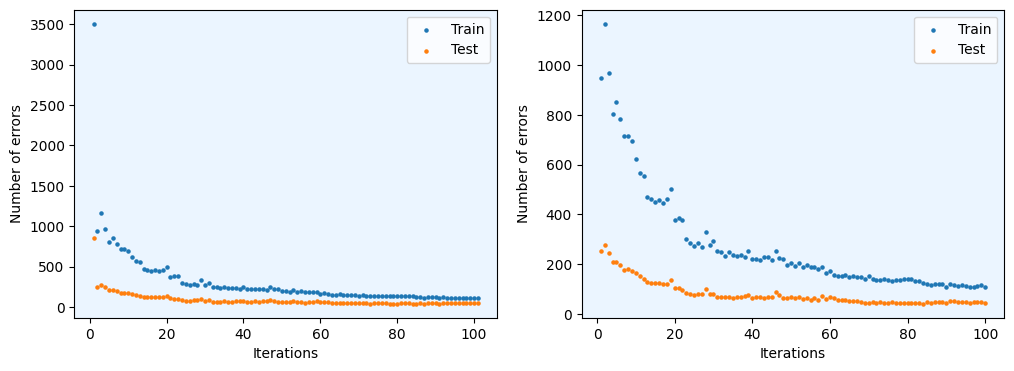

In [33]:
# This piece of code executes perceptron breaking at each encounter with tfidf

w = np.zeros(vectorised_train_data.shape[-1])
breaking = True
Perceptron_Classifier = Perceptron(w, breaking)
num_perceptron_iterations = 10**(1+1*breaking)
Perceptron_train_errors = np.zeros(num_perceptron_iterations+1, dtype='int')
Perceptron_test_errors = np.zeros(num_perceptron_iterations+1, dtype='int')
predicted_train_labels = Perceptron_Classifier.predict_labels(vectorised_train_data)
predicted_test_labels = Perceptron_Classifier.predict_labels(vectorised_test_data)
Perceptron_train_errors[0] = calculate_error(predicted_train_labels, train_labels)[0]
Perceptron_test_errors[0] = calculate_error(predicted_test_labels, test_labels)[0]
for i in range(num_perceptron_iterations):
    Perceptron_Classifier.progess_perceptron(vectorised_train_data, train_labels, 1)
    predicted_train_labels = Perceptron_Classifier.predict_labels(vectorised_train_data)
    predicted_test_labels = Perceptron_Classifier.predict_labels(vectorised_test_data)
    Perceptron_train_errors[i+1] = calculate_error(predicted_train_labels, train_labels)[0]
    Perceptron_test_errors[i+1] = calculate_error(predicted_test_labels, test_labels)[0]

Perceptron_predicted_labels = Perceptron_Classifier.predict_labels(vectorised_test_data)
print(calculate_error(predicted_train_labels, train_labels))
print(calculate_error(Perceptron_predicted_labels, test_labels))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, axis in enumerate(axes):
    axis.scatter(np.linspace(1, num_perceptron_iterations+1-i, num_perceptron_iterations+1-i), Perceptron_train_errors[i:], label='Train', s=5)
    axis.scatter(np.linspace(1, num_perceptron_iterations+1-i, num_perceptron_iterations+1-i), Perceptron_test_errors[i:], label='Test', s=5)
    axis.set_xlabel('Iterations')
    axis.set_ylabel('Number of errors')
    axis.set_facecolor('#ebf5ff')
    axis.legend()
plt.show()

(146, 96.8136185072021)
(57, 95.02617801047121)


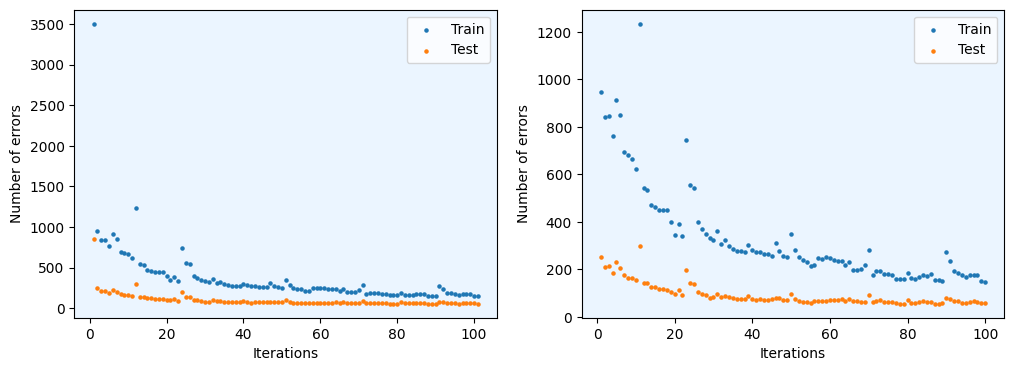

In [34]:
# this executes perceptron with breaking on count data

w = np.zeros(count_train_data.shape[-1])
breaking = True
Perceptron_Classifier = Perceptron(w, breaking)
num_perceptron_iterations = 10**(1+1*breaking)
Perceptron_ctrain_errors = np.zeros(num_perceptron_iterations+1, dtype='int')
Perceptron_ctest_errors = np.zeros(num_perceptron_iterations+1, dtype='int')
predicted_ctrain_labels = Perceptron_Classifier.predict_labels(count_train_data)
predicted_ctest_labels = Perceptron_Classifier.predict_labels(count_test_data)
Perceptron_ctrain_errors[0] = calculate_error(predicted_ctrain_labels, ctrain_labels)[0]
Perceptron_ctest_errors[0] = calculate_error(predicted_ctest_labels, ctest_labels)[0]
for i in range(num_perceptron_iterations):
    Perceptron_Classifier.progess_perceptron(count_train_data, ctrain_labels, 1)
    predicted_ctrain_labels = Perceptron_Classifier.predict_labels(count_train_data)
    predicted_ctest_labels = Perceptron_Classifier.predict_labels(count_test_data)
    Perceptron_ctrain_errors[i+1] = calculate_error(predicted_ctrain_labels, ctrain_labels)[0]
    Perceptron_ctest_errors[i+1] = calculate_error(predicted_ctest_labels, ctest_labels)[0]

Perceptron_cpredicted_labels = Perceptron_Classifier.predict_labels(count_test_data)
print(calculate_error(predicted_ctrain_labels, ctrain_labels))
print(calculate_error(Perceptron_cpredicted_labels, ctest_labels))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, axis in enumerate(axes):
    axis.scatter(np.linspace(1, num_perceptron_iterations+1-i, num_perceptron_iterations+1-i), Perceptron_ctrain_errors[i:], label='Train', s=5)
    axis.scatter(np.linspace(1, num_perceptron_iterations+1-i, num_perceptron_iterations+1-i), Perceptron_ctest_errors[i:], label='Test', s=5)
    axis.set_xlabel('Iterations')
    axis.set_ylabel('Number of errors')
    axis.set_facecolor('#ebf5ff')
    axis.legend()
plt.show()

(0, 100.0)
(17, 98.51657940663176)


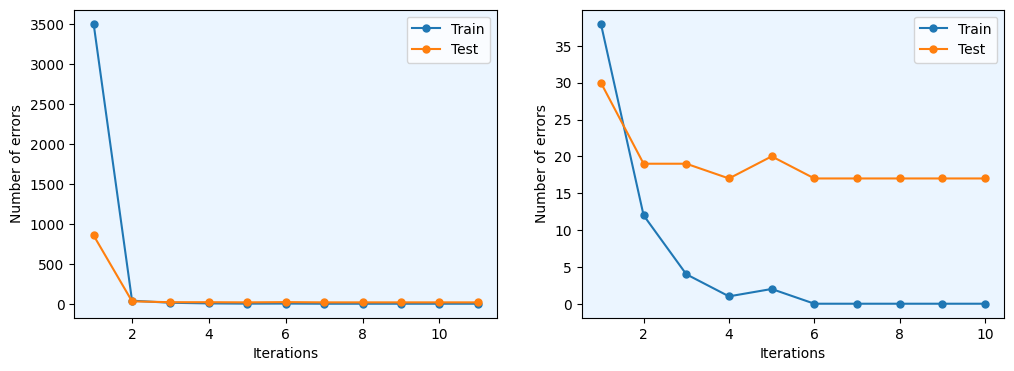

In [47]:
# This piece of code executes perceptron without breaking at each encounter

w = np.zeros(vectorised_train_data.shape[-1])
breaking = False
Perceptron_Classifier = Perceptron(w, breaking)
num_perceptron_iterations = 10**(1+1*breaking)
Perceptron_train_errors = np.zeros(num_perceptron_iterations+1, dtype='int')
Perceptron_test_errors = np.zeros(num_perceptron_iterations+1, dtype='int')
predicted_train_labels = Perceptron_Classifier.predict_labels(vectorised_train_data)
predicted_test_labels = Perceptron_Classifier.predict_labels(vectorised_test_data)
Perceptron_train_errors[0] = calculate_error(predicted_train_labels, train_labels)[0]
Perceptron_test_errors[0] = calculate_error(predicted_test_labels, test_labels)[0]
for i in range(num_perceptron_iterations):
    Perceptron_Classifier.progess_perceptron(vectorised_train_data, train_labels, 1)
    predicted_train_labels = Perceptron_Classifier.predict_labels(vectorised_train_data)
    predicted_test_labels = Perceptron_Classifier.predict_labels(vectorised_test_data)
    Perceptron_train_errors[i+1] = calculate_error(predicted_train_labels, train_labels)[0]
    Perceptron_test_errors[i+1] = calculate_error(predicted_test_labels, test_labels)[0]

Perceptron_predicted_labels = Perceptron_Classifier.predict_labels(vectorised_test_data)
Perceptron_train_predicted_labels = Perceptron_Classifier.predict_labels(vectorised_train_data)
print(calculate_error(Perceptron_train_predicted_labels, train_labels))
print(calculate_error(Perceptron_predicted_labels, test_labels))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, axis in enumerate(axes):
    axis.plot(np.linspace(1, num_perceptron_iterations+1-i, num_perceptron_iterations+1-i), Perceptron_train_errors[i:], label='Train', marker='o', markersize=5)
    axis.plot(np.linspace(1, num_perceptron_iterations+1-i, num_perceptron_iterations+1-i), Perceptron_test_errors[i:], label='Test', marker='o', markersize=5)
    axis.set_xlabel('Iterations')
    axis.set_ylabel('Number of errors')
    axis.set_facecolor('#ebf5ff')
    axis.legend()
plt.show()

(0, 100.0)
(26, 97.73123909249564)


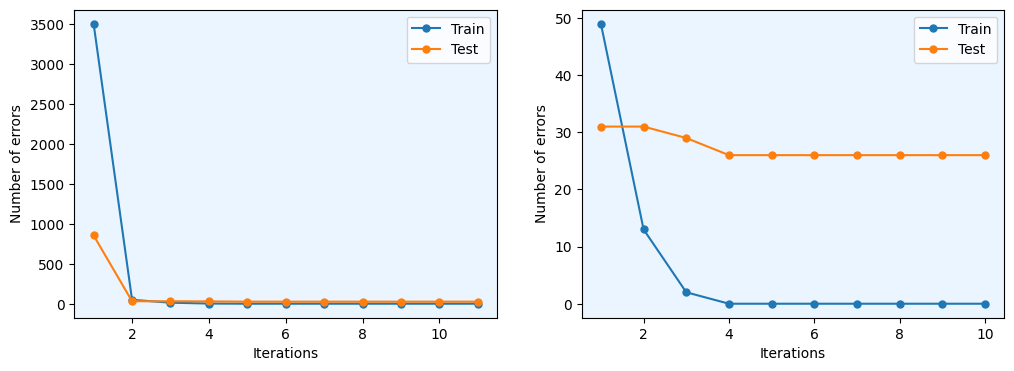

In [36]:
# this executes perceptron without breaking on count data

w = np.zeros(count_train_data.shape[-1])
breaking = False
Perceptron_Classifier = Perceptron(w, breaking)
num_perceptron_iterations = 10**(1+1*breaking)
Perceptron_ctrain_errors = np.zeros(num_perceptron_iterations+1, dtype='int')
Perceptron_ctest_errors = np.zeros(num_perceptron_iterations+1, dtype='int')
predicted_ctrain_labels = Perceptron_Classifier.predict_labels(count_train_data)
predicted_ctest_labels = Perceptron_Classifier.predict_labels(count_test_data)
Perceptron_ctrain_errors[0] = calculate_error(predicted_ctrain_labels, ctrain_labels)[0]
Perceptron_ctest_errors[0] = calculate_error(predicted_ctest_labels, ctest_labels)[0]
for i in range(num_perceptron_iterations):
    Perceptron_Classifier.progess_perceptron(count_train_data, ctrain_labels, 1)
    predicted_ctrain_labels = Perceptron_Classifier.predict_labels(count_train_data)
    predicted_ctest_labels = Perceptron_Classifier.predict_labels(count_test_data)
    Perceptron_ctrain_errors[i+1] = calculate_error(predicted_ctrain_labels, ctrain_labels)[0]
    Perceptron_ctest_errors[i+1] = calculate_error(predicted_ctest_labels, ctest_labels)[0]

Perceptron_cpredicted_labels = Perceptron_Classifier.predict_labels(count_test_data)
print(calculate_error(predicted_ctrain_labels, ctrain_labels))
print(calculate_error(Perceptron_cpredicted_labels, ctest_labels))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, axis in enumerate(axes):
    axis.plot(np.linspace(1, num_perceptron_iterations+1-i, num_perceptron_iterations+1-i), Perceptron_ctrain_errors[i:], label='Train',marker='o', markersize=5)
    axis.plot(np.linspace(1, num_perceptron_iterations+1-i, num_perceptron_iterations+1-i), Perceptron_ctest_errors[i:], label='Test', marker='o', markersize=5)
    axis.set_xlabel('Iterations')
    axis.set_ylabel('Number of errors')
    axis.set_facecolor('#ebf5ff')
    axis.legend()
plt.show()

(0, 100.0)
(5, 99.56369982547993)


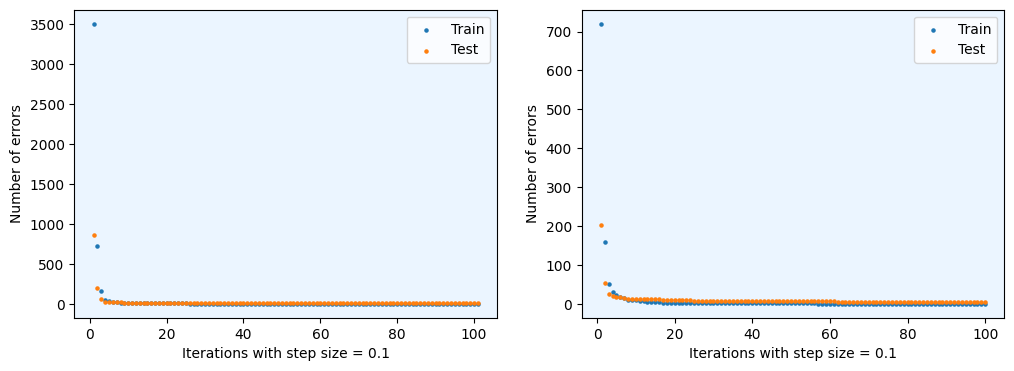

In [48]:
# Logistic Regression with Tfidfvectoriser

w = np.zeros(vectorised_data.shape[-1])
step_size = 0.1
LR_Classifier = Logistic_Regression(w, step_size)
num_LR_iterations = 100
LR_train_errors = np.zeros(num_LR_iterations+1, dtype='int')
LR_test_errors = np.zeros(num_LR_iterations+1, dtype='int')
predicted_train_labels = LR_Classifier.predict_labels(vectorised_train_data)
predicted_test_labels = LR_Classifier.predict_labels(vectorised_test_data)
LR_train_errors[0] = calculate_error(predicted_train_labels, train_labels)[0]
LR_test_errors[0] = calculate_error(predicted_test_labels, test_labels)[0]
for i in range(num_LR_iterations):
    LR_Classifier.progress_classifier(vectorised_train_data, train_labels, 1)
    predicted_train_labels = LR_Classifier.predict_labels(vectorised_train_data)
    predicted_test_labels = LR_Classifier.predict_labels(vectorised_test_data)
    LR_train_errors[i+1] = calculate_error(predicted_train_labels, train_labels)[0]
    LR_test_errors[i+1] = calculate_error(predicted_test_labels, test_labels)[0]

LR_predicted_labels = LR_Classifier.predict_labels(vectorised_test_data)
LR_train_predicted_labels = LR_Classifier.predict_labels(vectorised_train_data)
print(calculate_error(LR_train_predicted_labels, train_labels))
print(calculate_error(LR_predicted_labels, test_labels))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, axis in enumerate(axes):
    axis.scatter(np.linspace(1, num_LR_iterations+1 - i, num_LR_iterations+1 - i), LR_train_errors[i:], label='Train', s = 5)
    axis.scatter(np.linspace(1, num_LR_iterations+1 - i, num_LR_iterations+1 - i), LR_test_errors[i:], label='Test', s = 5)
    axis.set_xlabel('Iterations with step size = ' + str(step_size))
    axis.set_ylabel('Number of errors')
    axis.set_facecolor('#ebf5ff')
    axis.legend()
plt.show()

(18, 99.60715844609341)
(14, 98.77835951134381)


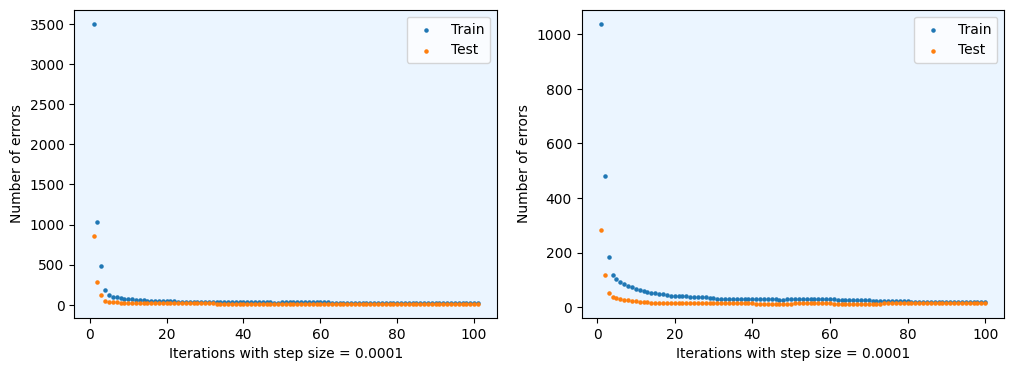

In [42]:
# Logistic Regression with Countvectoriser

w = np.zeros(count_data.shape[-1])
step_size = 1e-4
LR_Classifier = Logistic_Regression(w, step_size)
num_LR_iterations = 100
LR_ctrain_errors = np.zeros(num_LR_iterations+1, dtype='int')
LR_ctest_errors = np.zeros(num_LR_iterations+1, dtype='int')
predicted_ctrain_labels = LR_Classifier.predict_labels(count_train_data)
predicted_ctest_labels = LR_Classifier.predict_labels(count_test_data)
LR_ctrain_errors[0] = calculate_error(predicted_ctrain_labels, ctrain_labels)[0]
LR_ctest_errors[0] = calculate_error(predicted_ctest_labels, ctest_labels)[0]
for i in range(num_LR_iterations):
    LR_Classifier.progress_classifier(count_train_data, ctrain_labels, 1)
    predicted_ctrain_labels = LR_Classifier.predict_labels(count_train_data)
    predicted_ctest_labels = LR_Classifier.predict_labels(count_test_data)
    LR_ctrain_errors[i+1] = calculate_error(predicted_ctrain_labels, ctrain_labels)[0]
    LR_ctest_errors[i+1] = calculate_error(predicted_ctest_labels, ctest_labels)[0]

LR_cpredicted_labels = LR_Classifier.predict_labels(count_test_data)
print(calculate_error(predicted_ctrain_labels, ctrain_labels))
print(calculate_error(LR_cpredicted_labels, ctest_labels))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, axis in enumerate(axes):
    axis.scatter(np.linspace(1, num_LR_iterations+1 - i, num_LR_iterations+1 - i), LR_ctrain_errors[i:], label='Train', s = 5)
    axis.scatter(np.linspace(1, num_LR_iterations+1 - i, num_LR_iterations+1 - i), LR_ctest_errors[i:], label='Test', s = 5)
    axis.set_xlabel('Iterations with step size = ' + str(step_size))
    axis.set_ylabel('Number of errors')
    axis.set_facecolor('#ebf5ff')
    axis.legend()
plt.show()

In [49]:
NB_classifier = Naive_Bayes(vectorised_data.shape[-1])
NB_classifier.update_parameters(binary_train_data, train_labels)
NB_predicted_labels = NB_classifier.predict_labels(binary_test_data)
NB_train_predicted_labels = NB_classifier.predict_labels(binary_train_data)
NB_test_error = calculate_error(NB_predicted_labels, test_labels)[0]
print(calculate_error(NB_train_predicted_labels, train_labels))
print(calculate_error(NB_predicted_labels, test_labels))

(82, 98.21038847664775)
(30, 97.38219895287958)


In [50]:
# SVM on Tfidf data
SVM_classifier = svm.LinearSVC(dual='auto')
SVM_classifier.fit(vectorised_train_data, train_labels)
SVM_train_predicted_labels = SVM_classifier.predict(vectorised_train_data)
SVM_predicted_labels = SVM_classifier.predict(vectorised_test_data)
print(calculate_error(SVM_train_predicted_labels, train_labels))
print(calculate_error(SVM_predicted_labels, test_labels))

(0, 100.0)
(8, 99.30191972076788)


In [53]:
Best_train_predicted_labels = 1*(np.sum(np.array([Perceptron_train_predicted_labels, LR_train_predicted_labels, NB_train_predicted_labels, SVM_train_predicted_labels]), axis=0) >= 2)
Best_predicted_labels = 1*(np.sum(np.array([Perceptron_predicted_labels, LR_predicted_labels, NB_predicted_labels, SVM_predicted_labels]), axis=0) >= 2)
print(calculate_error(Best_train_predicted_labels, train_labels))
print(calculate_error(Best_predicted_labels, test_labels))

(0, 100.0)
(5, 99.56369982547993)
